In [83]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch import optim
import torch.functional as F
from sklearn.metrics import roc_auc_score

In [2]:
df = pd.read_csv('./currency.csv',header=[0],index_col=[0])

In [142]:
df = out[::-1].fillna(1)-1

In [143]:
df

AUDCAD    USDCHF    EURUSD    AUDUSD    GBPUSD    EURAUD  \
Year Month Day                                                               
2014 3     21  -0.001705  0.000680 -0.000029 -0.001309  0.000267  0.002316   
           23  -0.001204  0.001646 -0.002848 -0.003715 -0.000230  0.000000   
           24  -0.000987 -0.002616  0.001187 -0.003843 -0.002153  0.004601   
           25  -0.000479 -0.002079  0.002488 -0.006443 -0.002715  0.009881   
           26   0.001066 -0.001760  0.003290 -0.005158 -0.001783  0.006557   
...                  ...       ...       ...       ...       ...       ...   
2020 10    9    0.000232 -0.000923  0.001024  0.001466  0.001166 -0.000551   
           11   0.004327  0.001518  0.000254  0.003122 -0.002380 -0.002843   
           12   0.004389 -0.006774  0.006003  0.006733  0.010128 -0.000756   
           13   0.002610  0.001795  0.000068  0.003265 -0.005704 -0.003148   
           14   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

                  NZDCHF    EURCAD    NZDUSD  
Year Month Day                                
2014 3     21   0.000000 -0.000465 -0.000820  
           23   0.000000 -0.000297 -0.000421  
           24  -0.005773  0.004012 -0.003232  
           25  -0.005596  0.008490 -0.003546  
           26  -0.009202  0.009554 -0.007363  
...                  ...       ...       ...  
2020 10    9    0.000033 -0.000161  0.001050  
           11   0.004121  0.001472  0.002557  
           12  -0.006789  0.003615  0.000015  
           13   0.001383  0.000000 -0.000466  
           14   0.000000  0.000000  0.000000  

[2047 rows x 9 columns]

In [144]:
ret = np.array(df)+1
gamma = 0.99
trend = [np.log(ret[-1])]
for i in range(df.shape[0]-1):
    id = df.shape[0]-i
    trend.append(trend[-1]*gamma+np.log(ret[i]))
trend.reverse()
trend = pd.DataFrame(np.array(trend),index = df.index,columns=df.columns)

In [145]:
trend

AUDCAD    USDCHF    EURUSD    AUDUSD    GBPUSD    EURAUD  \
Year Month Day                                                               
2014 3     21  -0.006100  0.026380 -0.025020 -0.025894 -0.017108  0.000883   
           23  -0.008795  0.024835 -0.025341 -0.029449 -0.011502  0.004077   
           24  -0.013307  0.031952 -0.031643 -0.036524 -0.021798  0.004882   
           25  -0.017803  0.030742 -0.032219 -0.040041 -0.019610  0.007807   
           26  -0.018217  0.031985 -0.033578 -0.041925 -0.020986  0.008442   
...                  ...       ...       ...       ...       ...       ...   
2020 10    9   -0.004293 -0.002403  0.000836 -0.015194 -0.004820  0.016622   
           11  -0.003853 -0.000324 -0.001666 -0.008818 -0.002122  0.006858   
           12  -0.002894  0.002318 -0.002880 -0.005019  0.000034  0.002290   
           13  -0.001706  0.000680 -0.000029 -0.001310  0.000267  0.002314   
           14   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

                  NZDCHF    EURCAD    NZDUSD  
Year Month Day                                
2014 3     21   0.001980 -0.004664 -0.024417  
           23   0.000604 -0.004711 -0.024192  
           24   0.007491 -0.008404 -0.024452  
           25   0.003413 -0.009974 -0.027279  
           26   0.003414 -0.009912 -0.028615  
...                  ...       ...       ...  
2020 10    9   -0.011344  0.011676 -0.007966  
           11  -0.005790  0.003254 -0.004458  
           12   0.000000 -0.000757 -0.001233  
           13   0.000000 -0.000465 -0.000820  
           14   0.000000  0.000000  0.000000  

[2047 rows x 9 columns]

In [140]:
# target = 'CNY=X'
win_size = 120

In [146]:
X =[]
y =[]
for i in range(df.shape[0]-win_size):
    X.append(np.array(df.iloc[i:i+win_size])*100)
    y.append(np.array(trend.iloc[i+win_size]))

In [172]:
X = torch.tensor(np.array(X),dtype=torch.float32)
y = torch.tensor(np.array(y),dtype=torch.float32)

In [186]:
# 构建GRU
class GRU(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.gru = torch.nn.GRU(9,9, batch_first=True)
        self.linear = torch.nn.Linear(9, 9)
        self.linear.weight.data.norm()

    def forward(self, input_seq):
        output, _ = self.gru(input_seq, None)
        pred = output[:, -1, :]
        pred = torch.sigmoid(self.linear(pred))
        return pred

In [187]:
trainX = X[:int(X.shape[0]*0.9)]
testX = X[int(X.shape[0]*0.9):]
trainY = y[:int(X.shape[0]*0.9)]
testY = y[int(X.shape[0]*0.9):]

<AxesSubplot:xlabel='Year,Month,Day'>

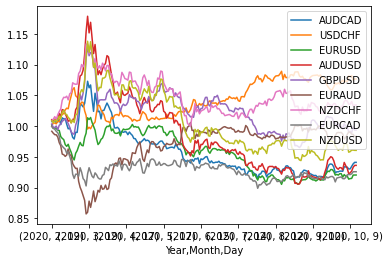

In [188]:
(df+1).iloc[int(df.shape[0]*0.9):].cumprod().plot()

In [189]:
epoch =1000
batch_size = 64
lr = 1e-4

list_x = []
list_y = []
list_ax = []
list_ay = []

rnn = GRU()

loss_function = nn.BCELoss()
optimizer = optim.Adam(rnn.parameters(), lr)
for epoch in range(epoch):
    epoch_loss = 0
    for batch in range(trainX.shape[0]//batch_size):
        start = batch_size*batch
        end = batch_size*(batch+1)
        output = rnn(trainX[start:end])
        loss = loss_function(output, (trainY[start:end]>0).float())
        running_loss = loss.item()
        epoch_loss+=running_loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(epoch,epoch_loss/batch,roc_auc_score((testY>0).float(),rnn(testX).detach()),(rnn(testX)>0.5).sum(axis = 0)/testX.size(0))
#     Loss = []
#
#     list_x.append(epoch)
#     list_y.append(loss.item())
#
#     if (epoch + 1) % 100 == 0:
#         list_ax.append(epoch)
#         list_ay.append(loss.item())
#         plt.plot(list_x, list_y, color='r', linewidth=3)
#         plt.scatter(list_ax, list_ay, marker='*', color='r')
#         plt.show()
#         Loss.append(running_loss)
#         print('Epoch: {}, Loss:{:.5f}, learning rate:{}'.format(epoch + 1, loss.item(), 1e-4))
#
# time_elapsed = time.time() - begin
# print('Training Complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

0 0.73923603617228 0.5056944032648407 tensor([0.0000, 0.0207, 0.0104, 0.3523, 0.0000, 0.0000, 0.0415, 0.0155, 0.9326])
1 0.7383069762816796 0.5062501068910641 tensor([0.0000, 0.0207, 0.0104, 0.3990, 0.0000, 0.0000, 0.0415, 0.0155, 0.9378])
2 0.737454700928468 0.5060939532175543 tensor([0.0000, 0.0207, 0.0104, 0.4715, 0.0000, 0.0000, 0.0466, 0.0155, 0.9378])
3 0.736615905394921 0.5080684908164937 tensor([0.0000, 0.0155, 0.0104, 0.5337, 0.0000, 0.0000, 0.0466, 0.0155, 0.9482])
4 0.7357891820944272 0.5096655672969532 tensor([0.0000, 0.0104, 0.0104, 0.5803, 0.0000, 0.0000, 0.0466, 0.0155, 0.9534])
5 0.7349740771146921 0.5112116705016974 tensor([0.0000, 0.0104, 0.0155, 0.6166, 0.0000, 0.0000, 0.0518, 0.0155, 0.9637])
6 0.7341701319584479 0.511524223316798 tensor([0.0000, 0.0104, 0.0207, 0.6580, 0.0000, 0.0000, 0.0518, 0.0155, 0.9689])
7 0.7333768010139465 0.5122818608575543 tensor([0.0000, 0.0052, 0.0207, 0.7047, 0.0000, 0.0000, 0.0570, 0.0155, 0.9689])
8 0.7325936418313247 0.51423807096320

KeyboardInterrupt: 

In [182]:
(testY>0).sum(axis = 0)/testY.shape[0]

tensor([0.6425, 0.1140, 0.8446, 0.2487, 0.3834, 0.9689, 0.2746, 0.9845, 0.5492])

tensor([[[-1.7049e-01,  6.8013e-02, -2.8990e-03,  ...,  0.0000e+00,
          -4.6490e-02, -8.1976e-02],
         [-1.2037e-01,  1.6464e-01, -2.8477e-01,  ...,  0.0000e+00,
          -2.9693e-02, -4.2141e-02],
         [-9.8743e-02, -2.6160e-01,  1.1868e-01,  ..., -5.7732e-01,
           4.0117e-01, -3.2320e-01],
         ...,
         [-6.6650e-02,  1.6525e-01, -6.2785e-02,  ..., -2.0550e-01,
           3.4229e-01, -3.6599e-01],
         [ 7.6941e-01, -1.3532e-01,  1.6771e-01,  ...,  7.6795e-02,
           4.1777e-02,  2.1889e-01],
         [-5.0902e-01,  4.0983e-01, -4.1084e-01,  ...,  3.8939e-01,
          -7.7201e-01, -6.2671e-02]],

        [[-1.2037e-01,  1.6464e-01, -2.8477e-01,  ...,  0.0000e+00,
          -2.9693e-02, -4.2141e-02],
         [-9.8743e-02, -2.6160e-01,  1.1868e-01,  ..., -5.7732e-01,
           4.0117e-01, -3.2320e-01],
         [-4.7882e-02, -2.0794e-01,  2.4882e-01,  ..., -5.5964e-01,
           8.4901e-01, -3.5461e-01],
         ...,
         [ 7.6941e-01, -1

In [ ]:
X.size

In [163]:
(rnn(testX)>0.5).sum(axis = 0)/testX.size(0)

tensor([1.0000, 0.0000, 1.0000, 1.0000, 1.0000, 0.0000, 1.0000, 0.9896, 1.0000])

In [79]:
trainY

tensor([[-3.1000e-03,  1.9722e-03,  3.6018e-03,  ...,  6.2678e-03,
         -7.0014e-03,  1.0997e-05],
        [-2.1176e-03,  2.1527e-03,  3.6382e-03,  ...,  6.2313e-03,
         -4.9931e-03,  1.2397e-05],
        [-3.0251e-03,  1.7693e-03,  3.3284e-03,  ...,  5.9946e-03,
         -4.6930e-03,  9.9449e-06],
        ...,
        [ 8.8820e-03,  1.3702e-02,  3.1949e-03,  ..., -1.2464e-02,
          8.4914e-03,  9.2460e-04],
        [ 9.7164e-03,  1.3524e-02,  3.1582e-03,  ..., -1.2229e-02,
          9.2388e-03,  9.3784e-04],
        [ 9.9423e-03,  1.3744e-02,  2.7484e-03,  ..., -1.2714e-02,
          8.9353e-03,  9.4992e-04]])

In [98]:
import os
filename = os.listdir('./DB1')[0]

In [108]:
out = pd.DataFrame()
for filename in os.listdir('./DB1'):
    df = pd.read_csv(f'./DB1/{filename}',sep = '\t',index_col=[0,1])
    out[filename[:-4]] = df['<CLOSE>'].pct_change()

In [110]:
out.dropna(inplace=True)

<AxesSubplot:xlabel='<DATE>,<TIME>'>

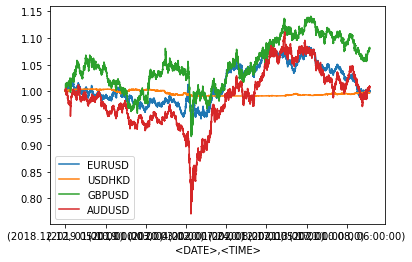

In [111]:
(out+1).cumprod().plot()

In [112]:
df = pd.read_csv('./Data/D_AUDCAD.csv')

In [113]:
df

,Year,Month,Day,Open,High,Low,Close,Volumn,Return,QPL1,...,QPL-3,QPL-4,QPL-5,QPL-6,QPL-7,QPL-8,QPL-9,QPL-10,QPL-11,QPL-12
0,2020,10,14,0.94102,0.94407,0.93775,0.93858,70000,1.000000,0.943023,...,0.911577,0.898086,0.883851,0.869124,0.854083,0.838863,0.823569,0.808283,0.793070,0.777983
1,2020,10,13,0.94517,0.94539,0.93951,0.94103,44218,1.002610,0.945484,...,0.913956,0.900430,0.886159,0.871393,0.856313,0.841053,0.825719,0.810393,0.795140,0.780014
2,2020,10,12,0.94925,0.94961,0.94431,0.94516,2712,1.004389,0.949634,...,0.917967,0.904382,0.890048,0.875217,0.860071,0.844744,0.829343,0.813949,0.798630,0.783437
3,2020,10,11,0.94860,0.94948,0.94762,0.94925,50766,1.004327,0.953743,...,0.921940,0.908295,0.893899,0.879005,0.863793,0.848400,0.832932,0.817472,0.802086,0.786827
4,2020,10,9,0.94636,0.95032,0.94568,0.94947,52729,1.000232,0.953964,...,0.922153,0.908506,0.894106,0.879208,0.863993,0.848596,0.833125,0.817661,0.802272,0.787010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2042,2014,3,26,1.02285,1.03145,1.02143,1.02335,56478,1.001066,1.028194,...,0.993908,0.979198,0.963678,0.947621,0.931222,0.914627,0.897952,0.881285,0.864698,0.848248
2043,2014,3,25,1.02185,1.02545,1.02130,1.02286,59060,0.999521,1.027702,...,0.993432,0.978729,0.963217,0.947167,0.930776,0.914189,0.897522,0.880863,0.864284,0.847842
2044,2014,3,24,1.02064,1.02411,1.01641,1.02185,4474,0.999013,1.026687,...,0.992451,0.977763,0.962266,0.946232,0.929857,0.913287,0.896635,0.879993,0.863430,0.847005
2045,2014,3,23,1.02050,1.02185,1.02034,1.02062,51348,0.998796,1.025451,...,0.991256,0.976586,0.961108,0.945093,0.928737,0.912187,0.895556,0.878934,0.862391,0.845985


In [116]:
out = pd.DataFrame()
for filename in os.listdir('./Data'):
    df = pd.read_csv(f'./Data/{filename}',index_col=[0,1,2])
    out[filename[2:-4]] = df['Return']

<AxesSubplot:xlabel='Year,Month,Day'>

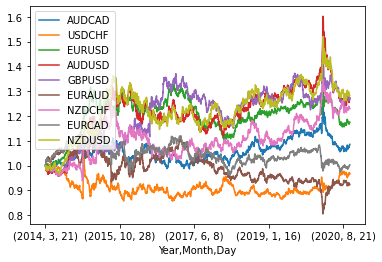

In [126]:
out[::-1].fillna(1).cumprod().plot()

In [190]:
(out[::-1].fillna(1)-1).to_csv('./qiu.csv')